## Chapter 2.2. Poems in periodicals: statistics

Load packages and periodicals data

In [13]:
library(tidyverse)

library(treemap)
library(ggplotify)
theme_set(theme_minimal())
library(wesanderson)

# fix problems with cyrillics
library(extrafont)
library(showtext)
font_add("Arial", "/Library/Fonts/Arial.ttf") 
showtext_auto()

Registering fonts with R

Ładowanie wymaganego pakietu: sysfonts

Ładowanie wymaganego pakietu: showtextdb


Dołączanie pakietu: ‘showtextdb’


Następujący obiekt został zakryty z ‘package:extrafont’:

    font_install




Load data

In [6]:
# periodicals
per <- read.csv("../../data/periodicals_lem.csv") %>% 
            select(-X) %>% 
            rename(author = Author_Initials,
                  year = Year, 
                  title = Text_title,
                  first_line = First_line) %>% 
            filter(year != 1834)
glimpse(per)

Rows: 1,402
Columns: 29
$ id               <chr> "P_8", "P_9", "P_10", "P_11", "P_12", "P_13", "P_14",…
$ txt_raw          <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "…
$ text             <chr> "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1"…
$ Unmed..0         <int> NA, 2873, 1232, NA, NA, 12698, NA, NA, NA, 12683, NA,…
$ author_nkrja     <chr> "", "Е. А. Баратынский", "Л. А. Якубович", "", "", "А…
$ A_ID             <chr> "A-74", "A-2", "A-50", "A-138", "A-139", "A-11", "A-1…
$ author           <chr> "Марков М.А.", "Баратынский Е.А.", "Якубович Л.А.", "…
$ title            <chr> "Русский царь", "Запустение", "Молния", "Аполог", "По…
$ first_line       <chr> "Достигнула Европа цели", "Я посетил тебя, пленительн…
$ PER_ID           <chr> "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ…
$ year             <int> 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835,…
$ Vol              <chr> "Т.8. Отд. 1", "Т.8. Отд. 1", "Т.8. Отд. 1", "Т.8. От…
$ Num           

In [7]:
# RNC data
load("../../data/nkrja_19th_lem.Rda")

rnc_authors <- c19 %>% 
    select(author) %>% 
    mutate(author = str_remove_all(author, "[[:space:]]|[[:punct:]]")) %>% 
    distinct() %>% 
    pull()

head(rnc_authors)

#rm(c19)

[1] "ССБобров"    "САТучков"    "ССПестов"    "ППСумароков" "НССмирнов"  
[6] "ПАСловцов"

In [8]:
print("Total number of authors in periodicals:")
per %>% 
    filter(!is.na(A_ID) & !is.na(author)) %>% # 1095 poems are with known author
    select(author) %>% 
    count(author, sort = T) %>% nrow() 

print("Number of authors with biography in RP:")
per %>% 
    filter(!is.na(RP_biography)) %>% 
    select(RP_biography) %>% 
    count(RP_biography, sort = T) %>% nrow() 

print("Number of authors included in RNC")
per %>% 
    filter(!is.na(author)) %>% 
    select(author) %>% 
    mutate(author = str_replace_all(author, "(.*?[[:space:]])(\\w\\.\\w.)", "\\2\\1")) %>% 
    mutate(author = str_remove_all(author, "[[:space:]]|[[:punct:]]")) %>% 
    distinct() %>% 
    filter(author %in% rnc_authors) %>% nrow()

[1] "Total number of authors in periodicals:"


[1] 164

[1] "Number of authors with biography in RP:"


[1] 101

[1] "Number of authors included in RNC"


[1] 54

## Textual intersections between RNC & periodicals
- Create for each poem an id column containing two first lines
- Mark the intersection with a special tag

In [9]:
periodicals <- per %>% 
    filter(n_lines > 3) %>%
    mutate(doublesCheck = str_extract(text_lemm, "^.*?\n.*?\n.*?\n")) %>% 
    mutate(doublesCheck = str_remove_all(doublesCheck, "[[:punct:]]|[[:space:]]"))

glimpse(periodicals)

Rows: 1,399
Columns: 30
$ id               <chr> "P_8", "P_9", "P_10", "P_11", "P_12", "P_13", "P_14",…
$ txt_raw          <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "…
$ text             <chr> "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1"…
$ Unmed..0         <int> NA, 2873, 1232, NA, NA, 12698, NA, NA, NA, 12683, NA,…
$ author_nkrja     <chr> "", "Е. А. Баратынский", "Л. А. Якубович", "", "", "А…
$ A_ID             <chr> "A-74", "A-2", "A-50", "A-138", "A-139", "A-11", "A-1…
$ author           <chr> "Марков М.А.", "Баратынский Е.А.", "Якубович Л.А.", "…
$ title            <chr> "Русский царь", "Запустение", "Молния", "Аполог", "По…
$ first_line       <chr> "Достигнула Европа цели", "Я посетил тебя, пленительн…
$ PER_ID           <chr> "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ…
$ year             <int> 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835,…
$ Vol              <chr> "Т.8. Отд. 1", "Т.8. Отд. 1", "Т.8. Отд. 1", "Т.8. От…
$ Num           

In [10]:
nkrja19 <- c19 %>% 
    rename(index = `Unnamed..0`,
          text_lemm = lemma) %>% 
    select(index, author, text_lemm) %>%
    mutate(doublesCheck = str_extract(text_lemm, "^.*?\n.*?\n.*?\n")) %>% 
    mutate(doublesCheck = str_remove_all(doublesCheck, "[[:punct:]]|[[:space:]]"))

glimpse(nkrja19)

Rows: 15,569
Columns: 4
$ index        <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…
$ author       <chr> "С. С. Бобров", "С. С. Бобров", "С. С. Бобров", "С. С. Бо…
$ text_lemm    <chr> "еще вкруг солнцев не вращаться \n в превыспренний страна…
$ doublesCheck <chr> "ещевкругсолнцевневращатьсявпревыспреннийстранамирещевхао…


In [14]:
doubles_id <- periodicals %>% 
    inner_join(nkrja19, by = "doublesCheck") %>% 
    select(index, id, year, author.x, author.y, doublesCheck, text_raw)

doubles_id %>% select(-text_raw) %>% head

,index,id,year,author.x,author.y,doublesCheck
,<int>,<chr>,<int>,<chr>,<chr>,<chr>
1,2873,P_9,1835,Баратынский Е.А.,Е. А. Баратынский,япосещатьтыпленительныйсеньневденьвеселыйживительныймайкогдазеленыйветвьпомавать
2,1232,P_10,1835,Якубович Л.А.,Л. А. Якубович,зачемснебесныйвысотаизгорнийжильеналонобурямчатьсяты
3,12698,P_13,1835,Пушкин А.С.,А. С. Пушкин,чтотыржатьмойконьретивыйчтотышеяопускатьнепотряхиватьгрива
4,5661,P_16,1835,Грибоедов А.С.,А. С. Грибоедов,живойлиямертвыйлияичтозачудныйвидение
5,12683,P_17,1835,Пушкин А.С.,А. С. Пушкин,корольходитьбольшойшагвзадивпередпопалатачеловекспатькорольлишьнеспаться
6,12684,P_18,1835,Пушкин А.С.,А. С. Пушкин,чтовразъездбитьянкомарнавиччтоондоманесидетьсяотчегодваночьонсряду


In [12]:
print("Total number of intersected texts:")
nrow(doubles_id)

print("Total number of texts in periodicals:")
nrow(periodicals)

print("Total % of intersected texts out for all periodicals texts:")
round( (nrow(doubles_id)/nrow(periodicals))*100 , 1) 

[1] "Total number of intersected texts:"


[1] 251

[1] "Total number of texts in periodicals:"


[1] 1399

[1] "Total % of intersected texts out for all periodicals texts:"


[1] 17.9

In [15]:
glimpse(doubles_id)

doubles_counts <- doubles_id %>% 
    count(year) %>% 
    mutate(group = "Периодика и НКРЯ")

doubles_counts %>% pivot_wider(names_from = year, values_from = n)

Rows: 251
Columns: 7
$ index        <int> 2873, 1232, 12698, 5661, 12683, 12684, 12685, 12687, 1268…
$ id           <chr> "P_9", "P_10", "P_13", "P_16", "P_17", "P_18", "P_19", "P…
$ year         <int> 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835, 183…
$ author.x     <chr> "Баратынский Е.А.", "Якубович Л.А.", "Пушкин А.С.", "Гриб…
$ author.y     <chr> "Е. А. Баратынский", "Л. А. Якубович", "А. С. Пушкин", "А…
$ doublesCheck <chr> "япосещатьтыпленительныйсеньневденьвеселыйживительныймайк…
$ text_raw     <chr> "Я посетил тебя, пленительная сень,\nНе в дни весёлые жив…


group,1835,1836,1837,1838,1839,1840
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
Периодика и НКРЯ,27,58,47,34,40,45


### Plot 2.2.1

In [16]:
rnc_1835 <- c19 %>% 
    rename(index = `Unnamed..0`) %>% 
    # remove intersection
    #anti_join(doubles_id %>% select(index), by = "index") %>%

    # calculate number of unique poems
    filter(year > 1834 & year < 1841) %>% 
    count(year, sort = F) %>% 
    mutate(group = "НКРЯ")

rnc_1835 %>% pivot_wider(names_from = year, values_from = n)

group,1835,1836,1837,1838,1839,1840
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
НКРЯ,196,149,180,146,238,303


In [17]:
counter_1835 <- per %>% 
    # remove intersection
    #anti_join(doubles_id %>% select(id), by = "id") %>%

    count(year, sort = F) %>% 
    mutate(group = "Периодика") %>%
    rbind(rnc_1835, doubles_counts)

counter_1835 %>% pivot_wider(names_from = year, values_from = n)

group,1835,1836,1837,1838,1839,1840
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
Периодика,220,229,263,203,245,242
НКРЯ,196,149,180,146,238,303
Периодика и НКРЯ,27,58,47,34,40,45


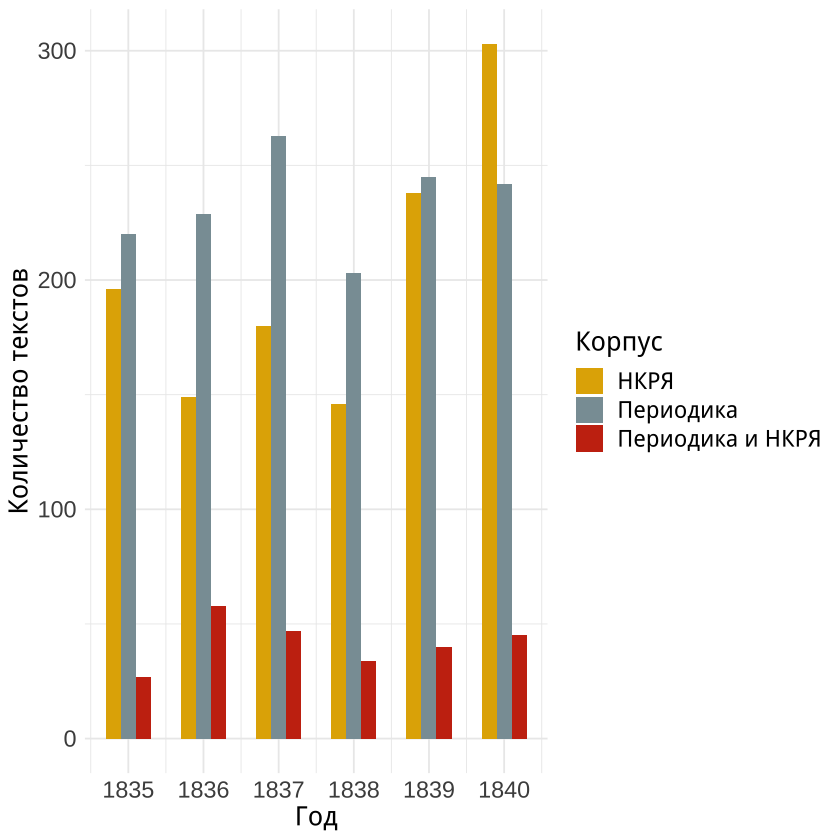

In [18]:
p2_2_1 <- counter_1835 %>%
    ggplot(aes(x = year, y = n, fill = group)) + 
    geom_col(position = "dodge", width = 0.6) + 
    scale_fill_manual(values = c(
                                wes_palette("Zissou1")[4],
                                wes_palette("Royal1")[1], 
                                wes_palette("Royal1")[2])) + 
    scale_x_continuous(breaks = 1835:1840) +
    theme(axis.text = element_text(size = 14),
         axis.title = element_text(size = 16),
         legend.title = element_text(size = 16, face = "bold"),
         legend.text = element_text(size = 14)) + 
    labs(x = "Год",
        y = "Количество текстов",
        fill = "Корпус")

p2_2_1

In [ ]:
# ggsave(file = "plots/fig2_2_1.png", plot = p2_2_1, dpi = 300,
#       width = 8, height = 6, bg = "white")

## Sources statistics
Analysis of poems published in different sources (journals & newspapers) and by different authors

In [19]:
glimpse(per)

Rows: 1,402
Columns: 29
$ id               <chr> "P_8", "P_9", "P_10", "P_11", "P_12", "P_13", "P_14",…
$ txt_raw          <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "…
$ text             <chr> "1", "1", "1", "1", "1", "1", "1", "1", "1", "1", "1"…
$ Unmed..0         <int> NA, 2873, 1232, NA, NA, 12698, NA, NA, NA, 12683, NA,…
$ author_nkrja     <chr> "", "Е. А. Баратынский", "Л. А. Якубович", "", "", "А…
$ A_ID             <chr> "A-74", "A-2", "A-50", "A-138", "A-139", "A-11", "A-1…
$ author           <chr> "Марков М.А.", "Баратынский Е.А.", "Якубович Л.А.", "…
$ title            <chr> "Русский царь", "Запустение", "Молния", "Аполог", "По…
$ first_line       <chr> "Достигнула Европа цели", "Я посетил тебя, пленительн…
$ PER_ID           <chr> "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ", "БдЧ…
$ year             <int> 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835,…
$ Vol              <chr> "Т.8. Отд. 1", "Т.8. Отд. 1", "Т.8. Отд. 1", "Т.8. От…
$ Num           

Load full metadata

In [24]:
per_full <- read.delim("../../meta/database_poems_published_in_journals.tsv", sep = "\t") %>% 
    rename(author = Author_Initials,
                  year = Year, 
                  title = Text_title,
                  first_line = First_line) %>% 
            filter(year != 1834)
glimpse(per_full)

Rows: 1,847
Columns: 21
$ text_ID          <chr> "P_1", "P_2", "P_3", "P_4", "P_5", "P_6", "P_7", "P_8…
$ txt_raw          <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "…
$ text             <chr> "", "", "", "", "", "", "", "1", "1", "1", "1", "1", …
$ Unmed..0         <int> NA, NA, NA, NA, NA, 8934, NA, NA, 2873, 1232, NA, NA,…
$ author_nkrja     <chr> "", "", "", "", "", "И. П. Мятлев", "", "", "Е. А. Ба…
$ A_ID             <chr> NA, NA, "A-137", NA, "A-17", NA, NA, "A-74", "A-2", "…
$ author           <chr> NA, NA, "Шишков А.С.", NA, "Цитович Н.Д.", NA, NA, "М…
$ title            <chr> "Солдатская песня", "Прощальная песнь", NA, NA, "Голо…
$ first_line       <chr> "Ох жизнь, молодецкая", "В последний раз еще встречая…
$ PER_ID           <chr> "Сев_пч", "Сев_пч", "Сев_пч", "Сев_пч", "Сев_пч", "Се…
$ year             <int> 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835, 1835,…
$ Vol              <chr> NA, NA, NA, NA, NA, NA, NA, "Т.8. Отд. 1", "Т.8. Отд.…
$ Num           

In [31]:
totals <- per_full %>% 
    group_by(year, PER_ID) %>% 
    count(sort = F) %>% 
    ungroup() %>% 
    rename(total_n = n) %>% 
    mutate(source = paste0(year, "_", PER_ID)) %>% 
    select(-year, -PER_ID)

# current state of digitisation

per %>% 
    group_by(year, PER_ID) %>% 
    count(sort = F) %>% 
    ungroup() %>% 
    mutate(source = paste0(year, "_", PER_ID)) %>% 
    left_join(totals, by = "source") %>% 
    select(-source) %>% 
    mutate(to_digitise = total_n - n)

year,PER_ID,n,total_n,to_digitise
<int>,<chr>,<int>,<int>,<int>
1835,БдЧ,65,65,0
1835,ЛПРИ,153,154,1
1835,МН,2,21,19
1836,БдЧ,53,57,4
1836,ЛПРИ,108,111,3
1836,МН,4,44,40
1836,СО,14,14,0
1836,Совр,50,50,0
1837,БдЧ,58,68,10


In [37]:
#todo <- per_full %>% 
#    rename(id = text_ID) %>% 
#    anti_join(per, by = "id")

#write.csv(todo, "per_todo.csv")

In [ ]:
per %>% group_by(year, PER_ID) %>% count() %>% 
    ggplot(aes(x = year, y = n, fill = PER_ID)) + geom_col()

In [ ]:
authors_sources <- per %>% 
    mutate(PER_ID = ifelse(str_detect(PER_ID,"СОиСА"), "СО", PER_ID)) %>% 
    filter(!is.na(author)) %>% 
    
    # grouping by author, year and source
    group_by(year, PER_ID, author) %>% 
    count(sort = T) %>% 
    ungroup() %>%
    
    # non-frequent authors grouped as "others"
    mutate(author = ifelse(n < 3, "Другие", author)) %>% 
    group_by(year, PER_ID, author) %>% 
    # sum poems by others
    summarise(n = sum(n)) %>% 
    mutate(author_label = paste0(author, " (", n, ")"))

head(authors_sources)

In [ ]:
light_palette <- 
    c(wes_palette("Chevalier1")[1], 
    wes_palette("Chevalier1")[2], 
    wes_palette("Chevalier1")[3], 
    wes_palette("Darjeeling2")[1], 
    wes_palette("Darjeeling2")[2], 
    wes_palette("Darjeeling2")[3])

In [ ]:
# treemap: https://cran.r-project.org/web/packages/treemap/treemap.pdf

x <- NULL

for (i in 1:length(unique(per$year))) {
    
    x <- unique(per$year)[i]
    
    filename = paste0("plots/treemaps/plot_", x, ".png")

    png(filename, width = 600, height = 600)

    t <- authors_sources %>% 
        filter(year == x) %>% 
        treemap(
            index = c("PER_ID", "author_label"),
            vSize = "n",
            type = "index",
            palette = light_palette,
            fontsize.labels = c(20, 16),
            #position.legend = "right",
            overlap.labels = 1,
            title = x,
            fontsize.title = 22
        )

    dev.off()
}

In [ ]:
authors_sources %>% 
        filter(year == 1835) %>% 
        treemap(
            index = c("PER_ID", "author_label"),
            vSize = "n",
            type = "index",
            palette = light_palette,
            fontsize.labels = c(20, 16),
            #position.legend = "right",
            overlap.labels = 1,
            title = "1835",
            fontsize.title = 22
        )